In [1]:
import numpy as np
import pandas as pd
import math

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler

In [3]:
# subset_col=['year','diqu','jigou_1','jigou_2', 'jigou_3', 'guanzhi','chushen_1','pinji_numeric', 'xitong']
df=pd.read_csv('../data/Jinshenlu.txt',sep='\t',
#                usecols=subset_col, 
              error_bad_lines=False)
# df.sample(frac=0.01).to_csv('../data/Jinshenlu_sample.csv', encoding='utf-8')

e:\hkust\learning\fyp\venv_fyt\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,14,15,16,25,27,29,30,31,32,33,35,36,37,43,44,45,46,47,48,49,50,51,54,55,56,57,58,60,63,66,68,71,73,74,84,89,90,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Curate the database: filter out the malformed for the moment.
1. Calculate the portion of malformed and some basic stats
2. remove malformed and irrelevant(fangkeben_only=0 qiren=0 exclude people without names)

Count how much are machu civilians

In [13]:
def convt(s):
    f=None
    try:
        f=float(s)
    except:
        pass
    return f
print((df['qiren']=='旗人').sum()/df.shape[0])
print((df['fangkeben_only']==1).sum()/df.shape[0])
print((df['xuhao'].apply(convt)>=20000).sum()/df.shape[0])

0.21570111636069703
0.04625493778798516
0.09660182127684154


In [7]:
print('no surname',df['xing'].isnull().sum())
print('no last name', df['ming'].isnull().sum())
print('no zihao', df['zihao'].isnull().sum())
print('no name at all', (df['xing'].isnull() & df['ming'].isnull() & df[ 'zihao'].isnull()).sum())

no surname 782335
no last name 194191
no zihao 2727832
no name at all 193626


Now remove all the irrelevant/malformed
xuhao >20k discarded

In [4]:
irr_idx=df[(df['qiren']=='旗人')|(df['fangkeben_only']==1) |
           (df['xing'].isnull() & df['ming'].isnull() & 
            df[ 'zihao'].isnull())].index.tolist()
malformed_idx=df[(df['year'].isin(['銀庫', '蒙古',7.0])) | 
                 (df['pinji_numeric']=='州') | df['year'].isnull() |
                df['qiren'].isnull() | (df['xuhao']=='麗')].index.tolist()
to_remove=set(irr_idx)|set(malformed_idx)

In [15]:
print(len(to_remove))

918912


In [5]:
df.drop(to_remove, inplace=True)
df['year']=df['year'].astype(float)
df['pinji_numeric']=df['pinji_numeric'].astype(float)
df['xuhao']=df['xuhao'].astype(int)

In [13]:
df.drop(df[df['xuhao']>=20000].index.tolist(), inplace=True)

In [23]:
print('pinji_detailed_numeric is more complete:',df['pinjin_detailed_numeric'].notnull().sum())
print('pinji_numeric has missing values', df['pinji_numeric'].notnull().sum())

2058889

## Up to this point every record has "year" and "品级"（not pinji_numeric）

Weird: 1880-1882 no records?

Text(0,0.5,'#Records')

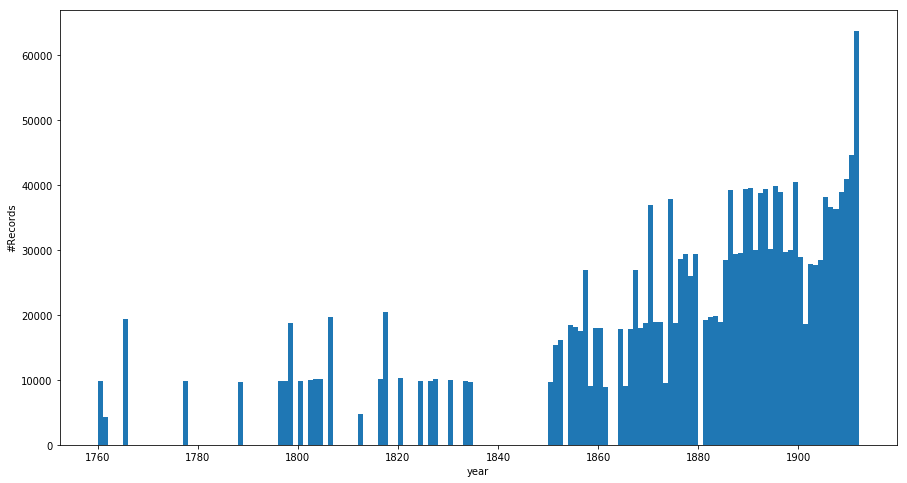

In [14]:
plt.figure(figsize=(15,8))
counts_ends=plt.hist(df['year'].dropna(), bins=np.arange(1760,1913))
plt.xlabel('year')
plt.ylabel('#Records')

Is that the real distribution of Qing civil servant's rankings?

Text(0,0.5,'#records')

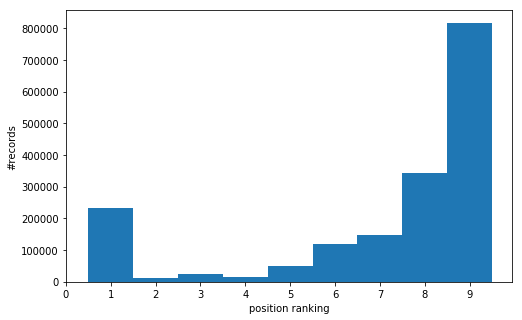

In [18]:
plt.figure(figsize=(8,5))
plt.hist(df['pinji_numeric'].dropna().astype(float), bins=9, align='right')
plt.xticks(np.arange(10))
plt.xlabel('position ranking')
plt.ylabel('#records')

## 13% records have unmatched rankings

In [16]:
def str2float(s):
    if s in [np.nan, '不入流', '未入流']:
        return 10.0
    if s=='從一品(應為正四品)':
        return 4.0
    dic=dict(zip(['一', '二','三','四','五', '六','七','八','九'], np.arange(1,10)))
    base = dic[s[-2]]
    base+=0.5*('從' in s)
    return float(base)
for i in df['pinji_detailed'].unique():
    print(i, 'converted into', str2float(i))

nan converted into 10.0
正八品 converted into 8.0
正七品 converted into 7.0
從九品 converted into 9.5
正六品 converted into 6.0
從五品 converted into 5.5
正五品 converted into 5.0
從七品 converted into 7.5
未入流 converted into 10.0
從六品 converted into 6.5
正二品 converted into 2.0
從四品 converted into 4.5
正九品 converted into 9.0
正四品 converted into 4.0
從三品 converted into 3.5
八品 converted into 8.0
正三品 converted into 3.0
從一品 converted into 1.5
正一品 converted into 1.0
從二品 converted into 2.5
從八品 converted into 8.5
從一品(應為正四品) converted into 4.0
三品 converted into 3.0
九品 converted into 9.0
四品 converted into 4.0
不入流 converted into 10.0
六品 converted into 6.0
一品 converted into 1.0
二品 converted into 2.0
七品 converted into 7.0
五品 converted into 5.0


In [17]:
df['pinji_detailed_numeric']=df['pinji_detailed'].apply(str2float)

In [23]:
unmatch_count=0

for (orig, gen) in df[['pinji_numeric', 'pinji_detailed_numeric']].values:
    if math.isnan(orig):
        continue
    else:
        unmatch_count+=int(orig)!=int(gen)
print(unmatch_count)

253959


Draw the diff distribution

In [25]:
diffs=[]
for (orig, gen) in df[['pinji_numeric', 'pinji_detailed_numeric']].values:
    if math.isnan(orig):
        continue
    else:
        if orig==0:
            orig=10
        diffs.append(gen - orig)

(array([1.124068e+06, 6.146500e+05, 0.000000e+00, 0.000000e+00,
        3.750000e+02, 0.000000e+00, 4.853000e+03, 0.000000e+00,
        9.963000e+03, 0.000000e+00, 2.315000e+03, 0.000000e+00,
        1.003000e+03, 0.000000e+00, 6.840000e+02, 0.000000e+00,
        2.687000e+03, 0.000000e+00, 1.410000e+02, 0.000000e+00]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ]),
 <a list of 20 Patch objects>)

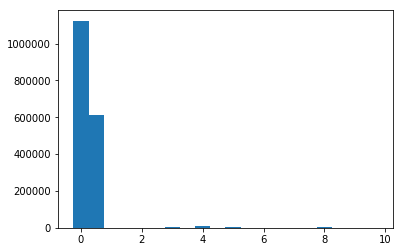

In [26]:
plt.hist(diffs, bins=np.arange(0,10.5,0.5), align='left')

In [27]:
pd.DataFrame(data=diffs).apply(lambda x: x> 0.6).sum()

0    22021
dtype: int64

### So there are 1% incorrect pinji_numeric

In [28]:
df['jicheng_hao'].unique()

array([1.0, 2.0, 3.0, nan, 4.0, 5.0, 6, 7, '3', '4', '2', '5', '6', '7'],
      dtype=object)

In [29]:
print(len(df['unique_id'].unique()))
print(df.shape)

256819
(2058889, 98)


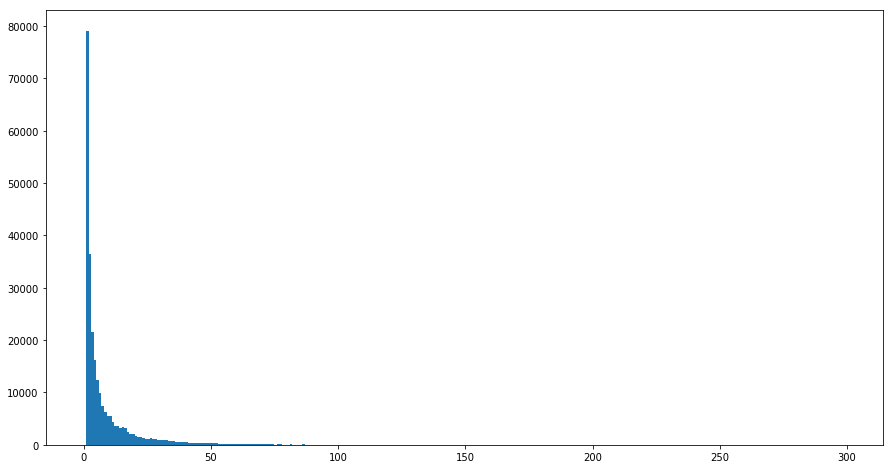

In [30]:
plt.figure(figsize=(15,8))
_=plt.hist(df['unique_id'].value_counts(), bins=np.arange(0,300))

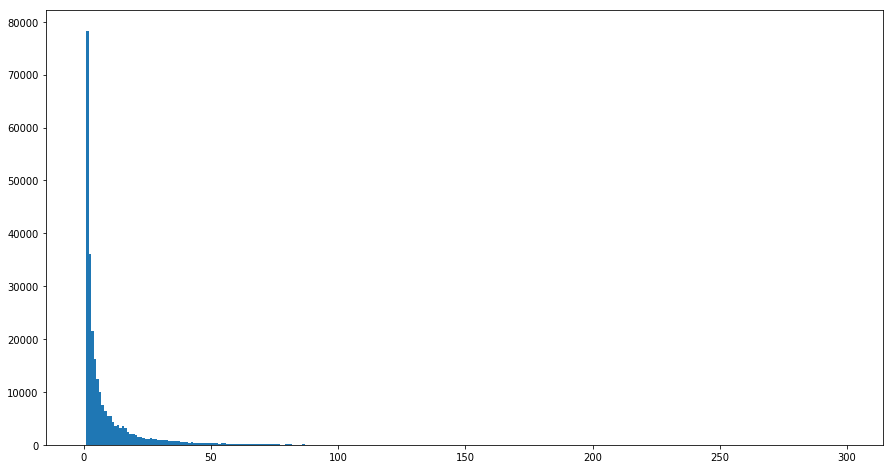

In [31]:
plt.figure(figsize=(15,8))
_=plt.hist(df[['unique_id', 'linked_record_count']].drop_duplicates()['linked_record_count'].dropna(), bins=np.arange(0,300))
# plt.hist(df['linked_record_count'].dropna(), )

Examine rankings in detail

In [78]:
min_arr=[]
for id_, subtable in tqdm(df[['unique_id','pinji_detailed_numeric']].groupby('unique_id')):
#     if subtable['pinjin_detailed_numeric'].isnull().all():
#         continue
    key=subtable['pinji_detailed_numeric'].max()
    arr=subtable['pinji_detailed_numeric'].dropna().values
    min_arr.append((key, arr))
sorted_min_arr=sorted(min_arr, key=lambda x:x[0])

In [79]:
points=[]
colors=[]
for i, (start,rankings) in tqdm(enumerate(sorted_min_arr)):
    for ranking in rankings:
        points.append([ranking, i])
        colors.append(start)
#     for itp in np.arange(rankings.min(), rankings.max(), 0.2):
#         points.append([itp, i])
points=np.array(points)

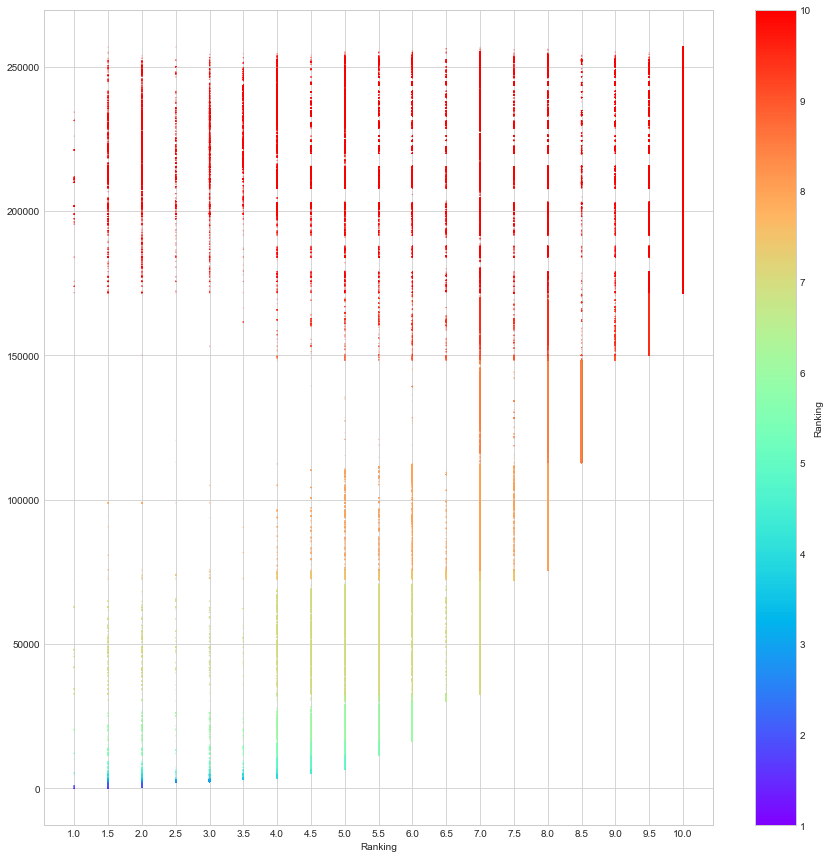

In [80]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,15))
plt.scatter(points[:,0],points[:,1],s=0.01, c=colors, cmap='rainbow')
plt.colorbar(label='Ranking')
plt.xlabel('Ranking')
_=plt.xticks(np.arange(1, 10.1,0.5))

In [14]:
count=0
for id_, subtable in tqdm(df[['unique_id','pinji_detailed_numeric']].groupby('unique_id')):
    if subtable['pinji_detailed_numeric'].notnull().any():
        count+=1
    else:
        print(id_)


In [15]:
print(count)
print(df['unique_id'].unique().shape[0])
print(count/df['unique_id'].unique().shape[0])

256818
256819
0.9999961062070952


Text(0,0.5,'#People')

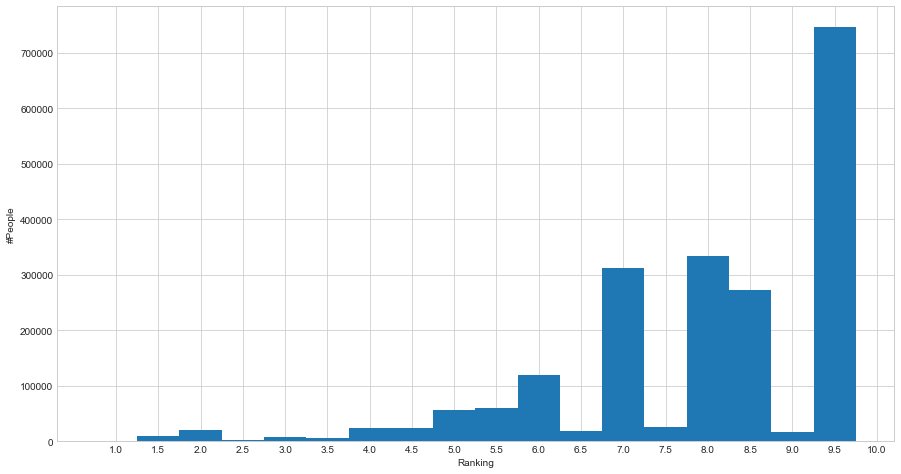

In [50]:
plt.figure(figsize=(15, 8))
plt.hist(df['pinjin_detailed_numeric'], align='left', bins=np.arange(1,10.4,0.5))
plt.xticks(np.arange(1,10.4,0.5))
plt.xlabel("Ranking")
plt.ylabel('#People')

## make heatmap

In [33]:
tmp=df[['unique_id','pinji_detailed_numeric']].groupby('unique_id').agg([np.min, np.max]).reset_index()

In [58]:
mat=tmp.pinji_detailed_numeric.groupby(['amin', 'amax']).agg(len).reset_index().rename(index=str,columns={0:'count'})

In [69]:
tem=pd.DataFrame(data=np.zeros((19,19)), index=np.arange(1.0, 10.5, 0.5), columns=np.arange(10.0, 0.5, -0.5))
for idx in tem.index:
    for col in tem.columns:
        if col<=idx:
            continue
        row=mat[(mat['amax']==col) & (mat['amin']==idx)]
        if row.shape[0]>0:
            tem[col][idx] = row['count'][0]
tem

,10.0,9.5,9.0,8.5,8.0,7.5,7.0,6.5,6.0,5.5,5.0,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0
1.0,19.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0
1.5,643.0,0.0,0.0,0.0,7.0,3.0,129.0,2.0,24.0,31.0,23.0,14.0,18.0,12.0,24.0,16.0,213.0,0.0,0.0
2.0,643.0,1.0,0.0,0.0,0.0,7.0,49.0,3.0,20.0,17.0,17.0,20.0,37.0,19.0,50.0,34.0,0.0,0.0,0.0
2.5,55.0,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,9.0,0.0,0.0,0.0,0.0
3.0,643.0,1.0,0.0,0.0,4.0,4.0,63.0,1.0,35.0,21.0,25.0,29.0,63.0,18.0,0.0,0.0,0.0,0.0,0.0
3.5,680.0,2.0,0.0,0.0,2.0,1.0,14.0,0.0,10.0,9.0,6.0,9.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,743.0,11.0,4.0,0.0,19.0,27.0,258.0,9.0,145.0,81.0,99.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.5,288.0,16.0,1.0,1.0,40.0,43.0,602.0,7.0,364.0,227.0,224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,1160.0,31.0,14.0,7.0,128.0,169.0,848.0,62.0,564.0,287.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.5,407.0,40.0,5.0,2.0,99.0,103.0,1361.0,109.0,585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(87,0.5,'highest career ranking')

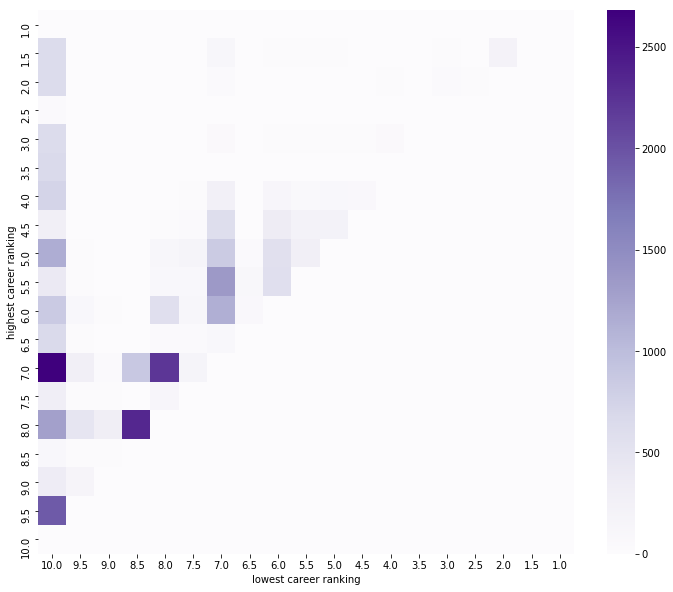

In [76]:
plt.figure(figsize=(12,10))
import seaborn as sns
sns.heatmap(tem, cmap='Purples')
ax=plt.gca()
ax.set_xlabel('lowest career ranking')
ax.set_ylabel('highest career ranking')

In [ ]:
1. the position components of the heated places

## Examine promotion speed of locality/position

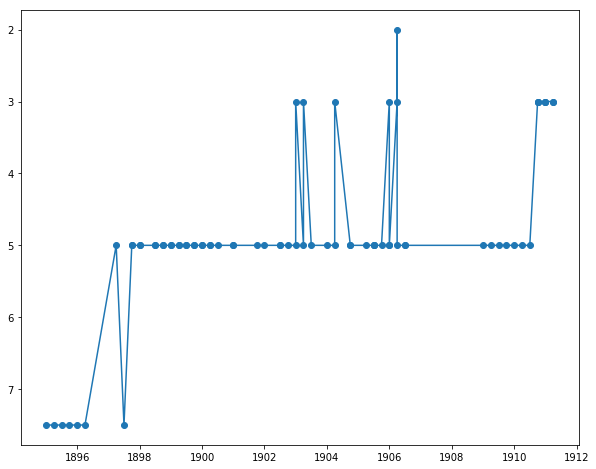

In [18]:
plt.figure(figsize=(10, 8))
plt.gca().invert_yaxis()
ps=df[df['unique_id']==189420028200.0][['unique_id','pinji_detailed_numeric', 'diqu',
                                     'jigou_1','jigou_2', 'guanzhi', 'quanxuan_year',
                                     'ganzhi_year_1','year', 'assigned_edition']]
plt.plot(ps['year'], ps['pinji_detailed_numeric'], 'o-')

In [108]:
ps # exclude after 1905, no houbu when duplicated in one edition, exclude people appearing only once

,unique_id,pinji_detailed_numeric,diqu,jigou_1,jigou_2,guanzhi,quanxuan_year,ganzhi_year_1,year,assigned_edition
2442432,1.894200e+11,7.5,京師,軍機處,漢二班,內閣候補中書,NaN,NaN,1895.00,光绪21春.xlsx
2442433,1.894200e+11,7.5,京師,軍機處,漢二班,內閣候補中書,NaN,NaN,1895.25,光绪21夏.xlsx
2442434,1.894200e+11,7.5,京師,軍機處,漢二班,內閣候補中書,NaN,NaN,1895.50,光绪21秋.xlsx
2442435,1.894200e+11,7.5,京師,軍機處,軍機章京,內閣候補中書,NaN,NaN,1895.75,光绪21冬.xlsx
2442436,1.894200e+11,7.5,京師,軍機處,軍機章京,內閣候補中書,NaN,NaN,1896.00,光绪22春.xlsx
2442437,1.894200e+11,7.5,京師,軍機處,漢二班,內閣候補中書,NaN,NaN,1896.25,光绪22夏爵秩全览.xlsx
2442438,1.894200e+11,5.0,京師,刑部衙門,額外司員,郎中,NaN,NaN,1897.25,光緒23夏.xlsx
2442439,1.894200e+11,7.5,京師,軍機處,軍機章京,內閣候補中書,NaN,NaN,1897.50,光緒23秋 縉紳全書.xlsx
2442440,1.894200e+11,5.0,京師,刑部衙門,額外司員,郎中,NaN,NaN,1897.75,光緒23冬.xlsx
2442441,1.894200e+11,5.0,京師,軍機處,漢二班,刑部候補郎中,NaN,NaN,1897.75,光緒23冬.xlsx




0. how to determine years? otherwise, we don't have any info about their promotion speed, given that 'year' variable cannot be trusted
1. completeness:1) before 1850 cannot be used correct. 2) after 1850, are all people tracked? for each person, is his records complete?
2. duplicate records: the same info duplicated by two 刻本 from different 书局？

now can only model each person by rankings. Features:
1. min, max, occurences, intervals 

In [113]:
def ave_interval(v):
    s=np.array(sorted(v))
    if s.shape[0]==1:
        return 0
    else:
        return (s[1:]-s[:-1]).mean()

In [22]:
filtered_df.groupby('unique_id').ngroups

83748

In [25]:
filtered_df.describe()

,unique_id,year,pinji_detailed_numeric
count,7.888840e+05,788884.000000,788884.000000
mean,1.868271e+11,1874.949647,7.984961
std,1.240559e+09,12.591239,1.695062
min,1.796113e+11,1850.500000,1.000000
25%,1.857302e+11,1866.000000,7.000000
50%,1.867314e+11,1875.500000,8.000000
75%,1.877306e+11,1886.000000,9.500000
max,1.898112e+11,1898.000000,10.000000


In [20]:
filtered_df=df[['unique_id','year','pinji_detailed_numeric']].groupby('unique_id').filter(lambda sf: sf['year'].min()>1850 and sf['year'].max()<1898.5)

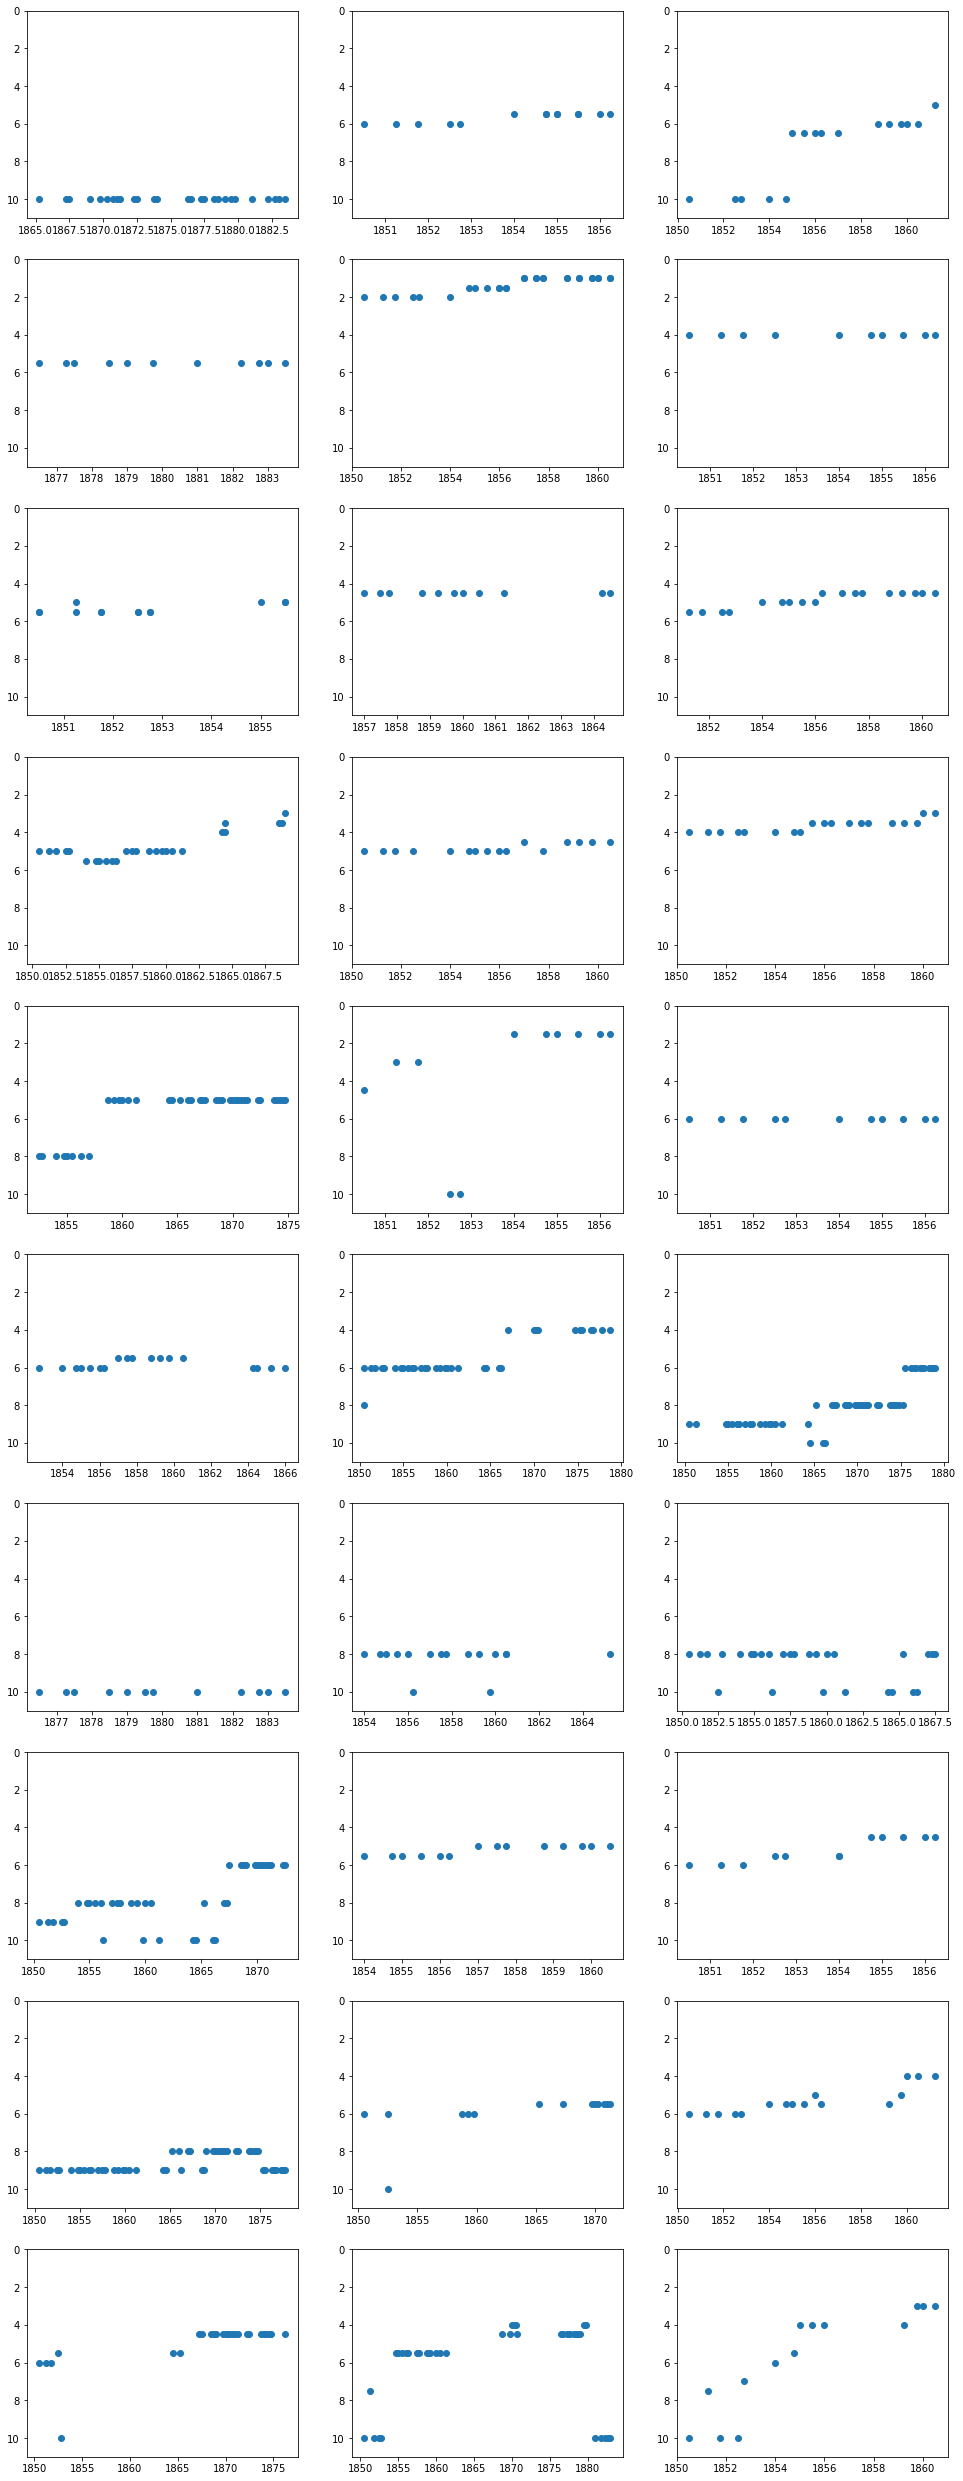

In [42]:
ncol=3
nrow=10
plt.figure(figsize=(ncol*5.5,nrow*4.5))
count=0
for i, (id_, subtable) in enumerate(filtered_df.groupby('unique_id'),1):
    
    if subtable.shape[0]<10:
        continue
    count+=1
    plt.subplot(nrow,ncol,count)
    plt.ylim(0,11)
    plt.gca().invert_yaxis()
    plt.plot(subtable['year'], subtable['pinji_detailed_numeric'], 'o')
    if count>=nrow*ncol:
        break

(0. remove outlier) -> vis the below three distribution -> cluster and project
1. change within a very small range
2. fluctuation or not: up and down ratio
3. how much promotion over career: last three - first three

In [122]:
def cal_up_times(subtable):
    last=-1
    up_count, down_count = 0, 0
    for ranking in subtable['pinji_detailed_numeric']:
        if last==-1:
            last=ranking
        else:
            if ranking>last:
                up_count+=1
    return up_count
stds=[]
short_count=0
spans=[]
promo_times=[]
promo_ratios=[]
for i, (id_, subtable) in tqdm(enumerate(filtered_df.groupby('unique_id'),1)):
    if subtable.shape[0]<4:
        short_count+=1
        continue
    stds.append(subtable['pinji_detailed_numeric'].std())
    spans.append(subtable['year'].max()-subtable['year'].min())
    promo_time=cal_up_times(subtable)
    promo_ratio=promo_time/subtable.shape[0]
    promo_times.append(promo_time)
    promo_ratios.append(promo_ratio)
    if i>1000:
        break

(array([700.,  33.,  25.,   4.,   4.,   7.,   3.,   5.,   6.,   4.]),
 array([0.        , 0.09705882, 0.19411765, 0.29117647, 0.38823529,
        0.48529412, 0.58235294, 0.67941176, 0.77647059, 0.87352941,
        0.97058824]),
 <a list of 10 Patch objects>)

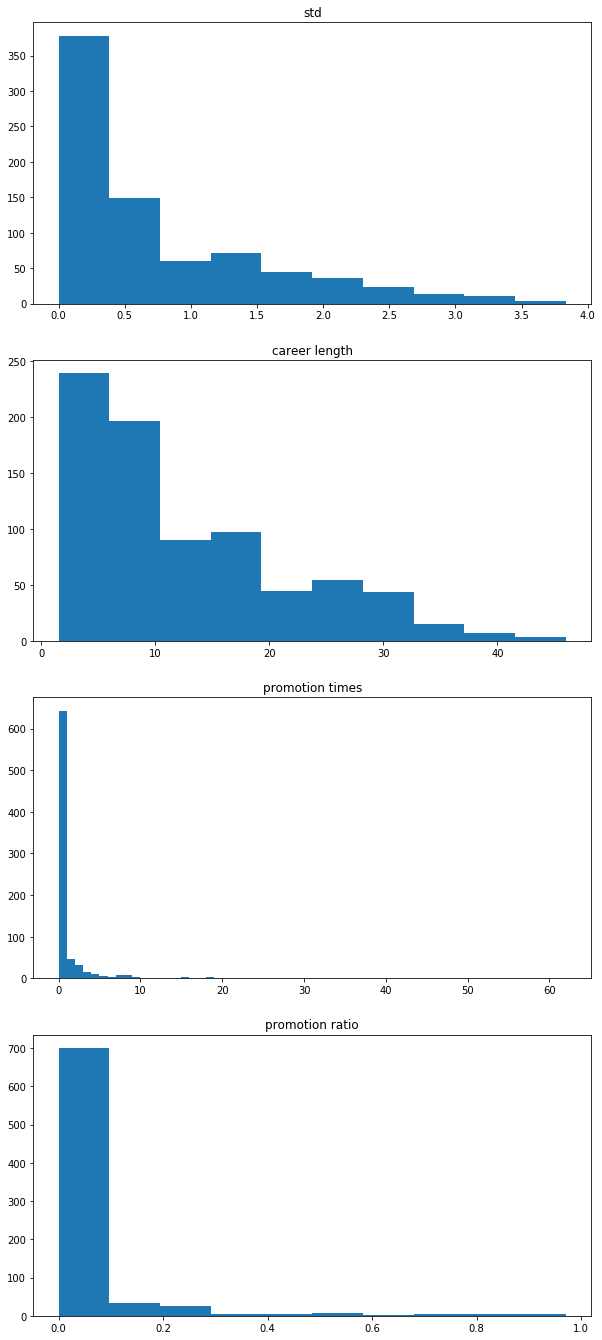

In [123]:
plt.figure(figsize=(10, 30))
plt.subplot(5,1,1)
plt.hist(stds)
plt.title('std')
plt.subplot(5,1,2)
plt.title('career length')
plt.hist(spans)
plt.subplot(5,1,3)
plt.title('promotion times')
plt.hist(promo_times, bins=np.arange(np.max(promo_times)))
plt.subplot(5,1,4)
plt.title('promotion ratio')
plt.hist(promo_ratios)

In [109]:
pd.Series(stds).isnull().sum()

101

In [77]:
def cal_zig_zag_ratio(subtable):
    last=-1
    up_count, down_count = 1, 0
    for ranking in subtable['pinji_detailed_numeric']:
        if last==-1:
            last=ranking
        else:
            if ranking>last:
                up_count+=1
            elif ranking<last:
                down_count+=1
    return down_count/up_count


fea_matrix={'fluc_range': [], 
            'zig_zag_ratio': [],
            'promo_scale':[],
            'promo_speed':[]
           }

for i, (id_, subtable) in tqdm(enumerate(filtered_df.groupby('unique_id'),1)):
    no_outlier_subtable=subtable[np.abs(subtable['pinji_detailed_numeric']-subtable['pinji_detailed_numeric'].mean())<
                                 (subtable['year'].std()*3)].sort_values(by='year') # remove outliers, sort by time
    if no_outlier_subtable.shape[0]<4 or no_outlier_subtable['pinji_detailed_numeric'].std()<0.001: # filter out people with too few records or no variance
        continue
    fea_matrix['fluc_range'].append(no_outlier_subtable['pinji_detailed_numeric'].max()-
                                    no_outlier_subtable['pinji_detailed_numeric'].min())
    fea_matrix['zig_zag_ratio'].append(cal_zig_zag_ratio(no_outlier_subtable))
    fea_matrix['promo_scale'].append(no_outlier_subtable['pinji_detailed_numeric'].iloc[:3].sum()-
                                     no_outlier_subtable['pinji_detailed_numeric'].iloc[-3:].sum())
    fea_matrix['promo_speed'].append(1/3*(no_outlier_subtable['pinji_detailed_numeric'].iloc[:3].sum()-
                                     no_outlier_subtable['pinji_detailed_numeric'].iloc[-3:].sum())/
                                    (no_outlier_subtable['year'].max()-no_outlier_subtable['year'].min()))
    if i>20000:
        break

In [78]:
fea_matrix=pd.DataFrame(fea_matrix)

In [138]:
fea_mat=StandardScaler().fit_transform(fea_matrix)
from sklearn.manifold import Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import locally_linear_embedding as LLE
from sklearn.manifold import TSNE
projs=TSNE(n_components=2).fit_transform(fea_mat)
# projs=LLE(fea_mat, n_neighbors=10,  n_components=2)[0]

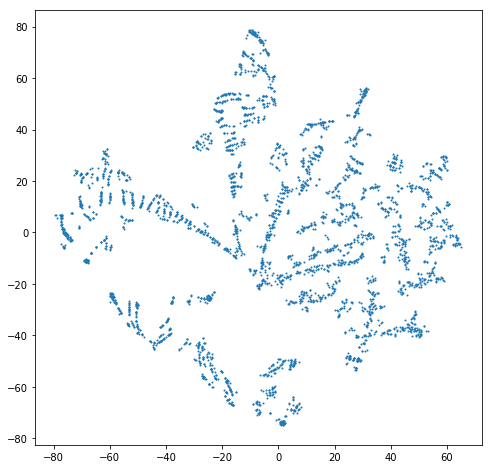

In [139]:
plt.figure(figsize=(8,8))
plt.plot(projs[:,0], projs[:,1], 'o', ms=1)

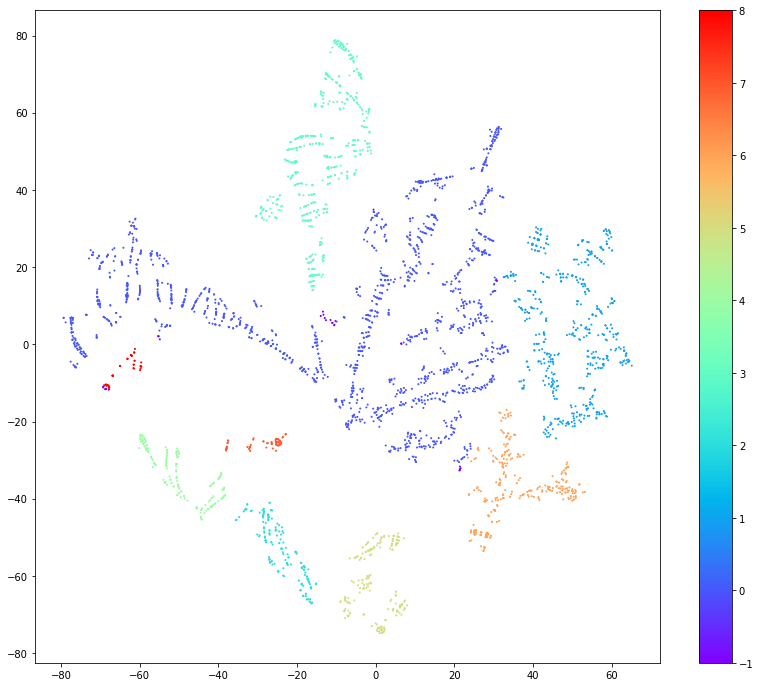

In [178]:
plt.figure(figsize=(14,12))
from sklearn.cluster import DBSCAN
fea_mat=pd.DataFrame(fea_mat, columns=fea_matrix.columns)
fea_mat['label']=DBSCAN(eps=6.7, min_samples=45).fit_predict(projs)
plt.scatter(projs[:,0], projs[:,1], s=np.full(fea_mat.shape[0],1),
            c=fea_mat['label'], cmap='rainbow')
plt.colorbar()

In [184]:
fea_matrix['label']=fea_mat['label']
fea_matrix.groupby('label').agg('mean')

,fluc_range,promo_scale,promo_speed,zig_zag_ratio
label,,,,
-1,1.914286,0.785714,0.015413,13.066667
0,1.717980,4.018781,0.081051,13.032088
1,2.720217,6.190433,0.296749,5.109580
2,2.000000,-3.544944,-0.224372,0.174090
3,1.000000,2.388235,0.079098,6.168897
4,0.671196,-1.326087,-0.064889,0.027174
5,4.618687,-8.537879,-0.197206,1.204629
6,5.843525,4.830935,0.089796,4.639361
7,1.689394,0.045455,0.000192,0.838489


### plt.figure(figsize=(12,10))
from sklearn.decomposition import PCA
projs=PCA(n_components=2).fit_transform(fea_mat)
plt.plot(projs[:,0], projs[:,1], 'o')

plan: 
1. (province level + ranking) -> speed
2. position -> speed
3. ...

In [12]:
(df['xuhao']>20000).sum()

234265

In [14]:
df[df['xuhao']==20000]

TypeError: 'NoneType' object is not subscriptable